In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import matplotlib.pyplot as plt
import time
import random as rd
import pandas as pd



In [3]:
class Task :
    def __init__(self,id, **kwargs):
        self.id = id
        self.workloads : dict[str,float] = {key : kwargs[key] for key in kwargs if key[0]=='M' and key[1:].isdigit()} if kwargs else {}
        
    def __str__(self) -> str:
        return "Task\n"+'\n'.join([f'{key} : {self.workloads[key]}' for key in self.workloads.keys()])

class TaskLoad :
    def __init__(self, l : list[Task] = []):
        self.tasks : dict[int,Task] = {t.id : t for t in l}
        self.machine_codes = sorted(list(set(key for t in l for key in t.workloads.keys())))

    @property
    def values(self):
        return list(self.tasks.values())

    def __len__(self):
        return len(self.tasks)
    
    def keys(self):
        return self.tasks.keys()

    def append(self, t : Task):
        self.tasks[t.id] = t 

    def __iter__(self):
        return iter(self.tasks)
    
    def __str__(self):
        return '\n'.join([str(t) for t in self.task_list])
    
    def __repr__(self):
        return self.__str__()
    
    def __getitem__(self, id):
        return self.tasks[id]
    
    def __setitem__(self, index, value):
        self.tasks[index] = value

    def pop(self, id):
        return self.tasks.pop(id)

class Machine : 
    def __init__(self, code: str):
        if code[0]=='M' and code[1:].isdigit():
            self.code = code
        else : raise ValueError('unkown machine code')

        self.schedule = []

    def __len__(self):
        return len(self.schedule)

    def __str__(self):
        return self.schedule
    
    def schedule_task(self, t : Task, time : float):
        if time < self.available_time : raise ValueError('this machine is not available at that time')

        self.schedule.append(
            {
                'start' :time,
                'end' : time +  t.workloads[self.code],
                'task' : t.id
            }
        )

    def reset_schedule(self):
        self.schedule = []

    @property
    def available_time(self) -> float:
        if len(self) == 0 : return 0
        return self.schedule[-1]['end']
    
class FlowShop :
    def __init__(self, tasks : TaskLoad):
        self.tasks = tasks
        self.machines = {code : Machine(code) for code in self.tasks.machine_codes}

    
    def johnson1(self) -> list [Task]:
        p = 1
        r = len(self.tasks)
        res = [None]*r
        if len(self.machines) >= 2 :

            machines_1 = {code : self.machines[code] for code in list(self.machines.keys())[:len(self.machines)//2]}
            machines_2 = {code : self.machines[code] for code in list(self.machines.keys())[len(self.machines)//2:]}

            
            init = 0
            while len(self.tasks) > 0 :
                for id in self.tasks :
                    t = self.tasks[id]
                    vms ={
                    'vm1' : sum(t.workloads[code] for code in machines_1.keys()),
                    'vm2': sum(t.workloads[code] for code in machines_2.keys())}
                    if init ==0 : 
                        i = t.id
                        k = min(vms, key = vms.get)
                        m = vms[k]
                    else : 
                        c = min(vms)
                        if c<m :
                            i = t.id
                            k = min(vms, key = vms.get)
                            m = t.workloads[k]

                t = self.tasks.pop(i)
                if k == 'vm1' :
                    res[p-1]= t
                    p+=1
                else :
                    res[r-1]= t
                    r-=1
            return res
        else : 
            return [self.tasks[t] for t in self.tasks]
        
    def johnson2(self) -> list[Task]:

        U = []
        V = []
        if len(self.machines) >= 2 :

            machines_1 = {code : self.machines[code] for code in list(self.machines.keys())[:len(self.machines)//2]}
            machines_2 = {code : self.machines[code] for code in list(self.machines.keys())[len(self.machines)//2:]}
            for id in self.tasks :
                t = self.tasks[id]
                vms ={
                    'vm1' : sum(t.workloads[code] for code in machines_1.keys()),
                    'vm2': sum(t.workloads[code] for code in machines_2.keys())}
                if vms['vm1']<vms['vm2']:
                    U.append({'task' :t, 'time' : vms['vm1']})
                else :
                    V.append({'task' :t, 'time' : vms['vm2']})
            LU = sorted(U, key = lambda x : x['time'])
            LV = sorted(V, key = lambda x : x['time'], reverse = True)
            res = [e['task'] for e in LU] + [e['task'] for e in LV]
            return res
        else : 
            return [t for t in self.tasks]

    def schedule(self, l : list[Task]) -> float:
        for t in l :
            piece_availability_time = float(0)
            for code in t.workloads :
                machine_availability_time=self.machines[code].available_time
                time = max(machine_availability_time, piece_availability_time)
                self.machines[code].schedule_task(t, time)
                piece_availability_time = self.machines[code].available_time

        end_of_processing  = max([machine.available_time for machine in self.machines.values()])
        
        return end_of_processing

    def plot_schedule(self):
        n = len (self.machines)
        i=1

        for machine_code in dict(sorted(self.machines.items())) : 
            for task in self.machines[machine_code].schedule :
                plt.plot([task['start'],task['end']],[n-i,n-i])
                plt.text((task['start']+task['end'])//2,n-i +0.25,task['task'], horizontalalignment='center',verticalalignment='center')
            i+=1
        plt.ylim(-1,n)
        plt.show()

    def schedule_test_duration_and_reset(self, l : list[Task]) -> float:
        d = self.schedule(l)
        for machine in self.machines :
            self.machines[machine].reset_schedule()
        return d
        
    def genetic(self,N : int, n: int, Pcross : float,Pmut : float) -> list[Task]:
        tasks = self.tasks.values
        P = []
        for i in range(N):
            rd.shuffle(tasks)
            P.append(tasks)
        generation_best=[]
        for i in range(n) :
            S = [{'ind':x, 'duration':self.schedule_test_duration_and_reset(x)} for x in P]
            S = sorted(S, key = lambda x : x['duration'])
            generation_best.append(S[0]['duration'])
            parents = [x['ind'] for x in S[:N]]
            rd.shuffle(parents)
            p1 = parents[:len(parents)//2]
            p2 = parents[len(parents)//2:]
            rd.shuffle(p1)
            rd.shuffle(p2)
            couples = zip(p1, p2)
            s_next=[]
            for parent1, parent2 in couples :
                if rd.random()>Pcross:
                    s_next.append(parent1)
                    s_next.append(parent2)
                else : 
                    a = rd.randint(0,len(parent1))
                    fils1 = [None]*len(parent1)
                    fils2 = [None]*len(parent1)
                    fils3 = [None]*len(parent1)
                    fils4 = [None]*len(parent1)
                    fils1[:a]=parent1[:a]
                    fils2[:a]=parent2[:a]
                    fils3[a:]=parent1[a:]
                    fils4[a:]=parent2[a:]
                    i=0
                    for t in parent2 :
                        if t not in fils1 :
                            fils1[a+i]=t
                            i+=1
                    i=0
                    for t in parent1 :
                        if t not in fils2 :
                            fils2[a+i]=t
                            i+=1
                    i=0
                    for t in parent2 :
                        if t not in fils3 :
                            fils3[i]=t
                            i+=1
                    i=0
                    for t in parent1 :
                        if t not in fils4 :
                            fils4[i]=t
                            i+=1
                    
                    s_next.append(fils1)
                    s_next.append(fils2)
                    s_next.append(fils3)
                    s_next.append(fils4)
                    
            p_next = []
            for ind in s_next :

                if rd.random() > Pmut :
                    p_next.append(ind)
                else :
                    i1 = rd.randint(0,len(ind)-1)
                    i2 = rd.randint(0,len(ind)-1)
                    nind = ind.copy()
                    nind[i1], nind[i2] = nind[i2], nind[i1]
                    p_next.append(nind)
            P = p_next
        S = [{'ind':x, 'duration':self.schedule_test_duration_and_reset(x)} for x in P]
        S = sorted(S, key = lambda x : x['duration'])
        return S[0]['ind'], generation_best

    def plot_genetic(self, N, n):
        s,conv = self.genetic(N, n, rd.random(),rd.random())
        d = self.schedule(s)
        print(f'duration : {d}')
        print('convergence curve :')
        plt.plot(conv)
        plt.show()
        self.plot_schedule()



    def plot_johnson1(self):
        d = self.schedule(self.johnson1())
        print(f'duration : {d}')
        self.plot_schedule()

    def plot_johnson2(self):
        d = self.schedule(self.johnson2())
        print(f'duration : {d}')
        self.plot_schedule()

In [4]:
input_list = [Task(1,M1 = 6,M2 = 1, M3 = 5),
     Task(2,M1 = 3, M2 = 5, M3 = 8),
     Task(3,M1 = 10,M2 = 4, M3 = 1),
     Task(4,M1 = 14,M2 = 6, M3 = 3),
     Task(5,M1 = 5,M2 = 10, M3 = 6),
     Task(6,M1 = 9,M2 = 6, M3 = 10),
     Task(7,M1 = 7,M2 = 9, M3 = 12),
     Task(8,M1 = 11,M2 = 8, M3 = 9),
     Task(9,M1 = 2,M2 = 6, M3 = 6),
     Task(10,M1 = 3,M2 = 1, M3 = 7)]

duration : 79


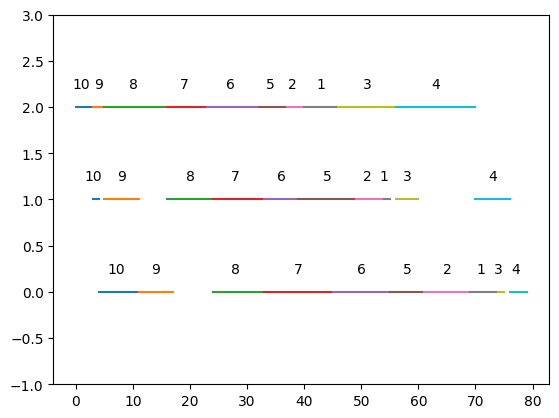

execution : 0.37004661560058594


In [5]:
shop = FlowShop(TaskLoad(input_list))
start = time.time()
shop.plot_johnson1()
stop = time.time()

print(f'execution : {stop - start}')

duration : 75


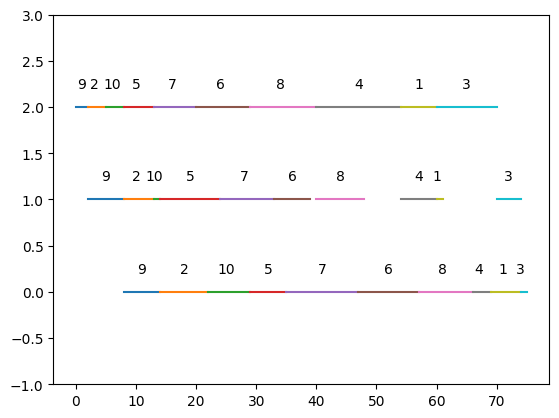

execution : 0.3166677951812744


In [6]:
shop = FlowShop(TaskLoad(input_list))
start = time.time()
shop.plot_johnson2()
stop = time.time()

print(f'execution : {stop - start}')

duration : 77
convergence curve :


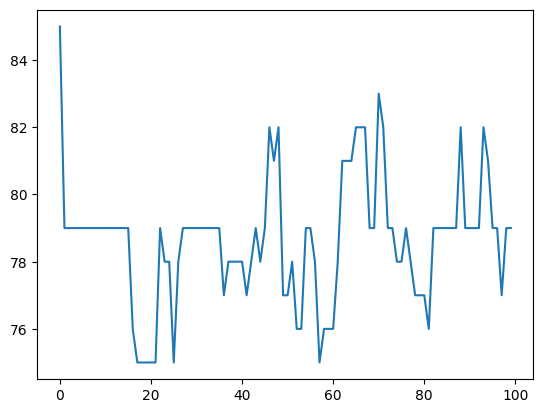

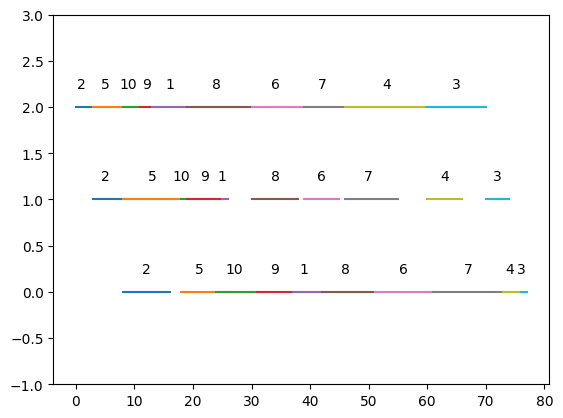

execution : 0.8667986392974854


In [7]:
shop = FlowShop(TaskLoad(input_list))
start = time.time()
shop.plot_genetic(15, 100)
stop = time.time()
print(f'execution : {stop - start}')

In [8]:
df = pd.read_excel('C:/Users/jules/Downloads/data_PTV_Fil_rouge/data_PTV_Fil_rouge/2_detail_table_customers.xls')

In [9]:
df

,ROUTE_ID,CUSTOMER_NUMBER,CUSTOMER_CODE,CUSTOMER_LATITUDE,CUSTOMER_LONGITUDE,CUSTOMER_TIME_WINDOW_FROM_MIN,CUSTOMER_TIME_WINDOW_TO_MIN,NUMBER_OF_ARTICLES,TOTAL_WEIGHT_KG,TOTAL_VOLUME_M3,CUSTOMER_DELIVERY_SERVICE_TIME_MIN,
0,2946091,1,138087,43.413050,17.875880,480,900,42.0,64.318000,0.320000,19.94,
1,2946091,2,138157,43.135963,17.776839,480,900,14.0,17.553000,0.046000,11.36,
2,2946091,3,26,43.469078,17.337022,481,961,4.0,6.378000,0.041000,8.73,
3,2946091,4,478,43.707160,17.222900,481,961,5.0,16.375000,0.046000,9.10,
4,2946091,5,921127,43.082228,17.960037,480,840,16.0,18.939000,0.074000,11.99,
...,...,...,...,...,...,...,...,...,...,...,...,...
1153,3044702,87,1938,43.257390,18.113070,481,961,5.0,7.886550,0.037284,12.50,
1154,3044702,88,131742,42.869100,18.425580,481,961,15.0,37.681000,0.355000,17.50,
1155,3044702,89,1805,43.381760,17.591550,481,961,2.0,114.972000,0.140000,11.00,
1156,3044702,90,957,44.073827,17.448408,481,961,8.0,56.385000,0.190000,14.00,


In [10]:
df['CUSTOMER_CODE'].nunique()

573

In [5]:
from math import radians, cos,sin,  atan2, sqrt
from tqdm.notebook import trange
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.img_tiles import OSM


class Lieu():
    R_TERRE = 6373.0
    def __init__(self , id : int, longitude : float, latitude : float):
        self.id = id
        self.longitude = longitude
        self.latitude = latitude

    def distance(self, other ) -> float:
        
        dlat = radians(other.latitude - self.latitude)
        dlon = radians(other.longitude - self.longitude)
        a = sin(dlat / 2)**2 + cos(self.latitude) * cos(other.latitude) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        return self.R_TERRE * c

    def __str__(self):
        return f'Lieu {self.id}'
    
class Client(Lieu):
    def __init__(self, id : int, longitude : float, latitude : float,  demande : float):
        super().__init__(id, longitude, latitude)
        self.demande = demande
    
    def __str__(self):
        return f'{self.id}'
    
    def __repr__(self):
        return f'{self.id}'
    
class Depot(Lieu):
    def __init__(self, id : int, longitude : float, latitude : float):
        super().__init__(id, longitude, latitude)

    def __str__(self):
        return f'Depot {self.id}'

    def __repr__(self):
        return f'Depot {self.id}'
        


class SolutionFinale():
    def __init__(self, schedule : dict[Vehicule,list[Lieu]], probleme): 
        self.schedule = schedule
        self.probleme = probleme

    @property   
    def nb_vehicles(self) -> int :
        return len(self.schedule)

    def impose_capacity_constraint(self):
        for vehicule in self.schedule :
            N= len(self.schedule[vehicule])
            if N == 0 : pass
            done = []
            to_do = self.schedule[vehicule]
            while to_do :
                next = to_do.pop(0)
                if isinstance(next, Client) and next.demande > vehicule.mesure_load(done) :
                    done.append(self.probleme.depot)
                done.append(next)
            self.schedule[vehicule] = done


    def score (self) -> float :
        self.impose_capacity_constraint()
        for vehicule in self.schedule :
            if len(self.schedule[vehicule]) >0 and not isinstance(self.schedule[vehicule][-1], Depot) : 
                self.schedule[vehicule].append(self.probleme.depot)
            if len(self.schedule[vehicule]) >0 and not isinstance(self.schedule[vehicule][0], Depot) :
                self.schedule[vehicule].insert(0, self.probleme.depot)
        c = self.nb_vehicles * self.probleme.cout_vehicule
        distances = [vehicule.mesure_distance(self.schedule[vehicule]) for vehicule in self.schedule]
        c += sum(distances) +max(distances)*self.nb_vehicles
        return c

    def score_2(self) -> float:
        if self._score is not None:
            return self._score  # Retourner le score précédemment calculé si disponible

        total_cost = self.nb_vehicles * self.probleme.cout_vehicule

        for vehicle, path in self.schedule.items():
            # Créer une copie temporaire de l'itinéraire pour le véhicule
            temp_path = [self.probleme.depot] if not isinstance(path[0], Depot) else path[:]
            if len(path) > 0 and not isinstance(path[-1], Depot):
                temp_path.append(self.probleme.depot)

            # Calculer la distance pour le chemin temporaire
            distance = vehicle.mesure_distance(temp_path)
            total_cost += distance

        self._score = total_cost  # Mémoriser le score calculé
        return self._score

    def __str__(self):
        return str(self.schedule)
    
    def plot(self):
        self.impose_capacity_constraint()
        print(self.nb_vehicles)
        print()
        for vehicule in self.schedule :
            if len(self.schedule[vehicule]) > 1 and not isinstance(self.schedule[vehicule][-1], Depot) : 
                self.schedule[vehicule].append(self.probleme.depot)
            if len(self.schedule[vehicule]) > 1 and not isinstance(self.schedule[vehicule][0], Depot) :
                self.schedule[vehicule].insert(0, self.probleme.depot)
        fig = plt.figure(figsize = (7,7))
        ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
        imagery = OSM()
        ax.add_image(imagery, 9)
        for vehicule in self.schedule :
            if len(self.schedule[vehicule]) > 1 :
                ax.plot([l.longitude for l in self.schedule[vehicule]], [l.latitude for l in self.schedule[vehicule]])
                #for l in self.schedule[vehicule] :
                    #plt.text(l.longitude , l.latitude, str(l.id), horizontalalignment='center',verticalalignment='center')
        ax.plot(self.probleme.depot.longitude, self.probleme.depot.latitude, 'ro')
        plt.figure()
        i = 0
        for vehicule in self.schedule :
            if len(self.schedule[vehicule])>1 :
                origin = self.schedule[vehicule][0]
                time = 0
                #plt.text(0,len(self.schedule)-i, self.schedule[vehicule][0], horizontalalignment='center',verticalalignment='center')
                for j in range(1,len(self.schedule[vehicule])) :
                    plt.plot([time, time + origin.distance(self.schedule[vehicule][j])], [len(self.schedule)-i-j/len(self.schedule[vehicule]),len(self.schedule)-i-j/len(self.schedule[vehicule])])
                    #plt.text(time + origin.distance(self.schedule[vehicule][j]), len(self.schedule)-i-(j+0.5)/len(self.schedule[vehicule]), self.schedule[vehicule][j], horizontalalignment='center',verticalalignment='center')
                    time += origin.distance(self.schedule[vehicule][j])
                    origin = self.schedule[vehicule][j]
                i+=1
        plt.figure()



        


class SimpleVRP() :
    def __init__(self, clients : list[Client], depot : Depot, cout_vehicule : float, capacite_vehicule : float):
        self.clients = clients
        self.cout_vehicule = cout_vehicule
        self.depot = depot
        self.capacite_vehicule = capacite_vehicule
    
    def gen_random_solution(self, n_transports: int):
        rd.shuffle(self.clients)
        return Solution(self.clients,n_transports, self)
    

    def genetic(self, N_pop : int, n_iter: int, initial_n_transports: int, Pcross : float,Pmut : float) -> tuple[SolutionFinale, list[float]]:
        P=[]
        for i in range(N_pop):
            P.append(self.gen_random_solution(initial_n_transports))
        generation_best : list[Solution] = []        
        for i in trange(n_iter):
            S = sorted(P, key = lambda x : x.score())
            S = S[:N_pop]
            generation_best.append(S[0])
            nex_gen : list[Solution]= []
            for p1, p2 in zip(S[::2], S[1::2]):
                nex_gen.extend(p1.cross(p2, Pcross))
            rd.shuffle(nex_gen)
            P: list [Solution] = [x.mutate(Pmut) for x in nex_gen]
        S = sorted(P, key = lambda x : x.score())
        generation_best.append(S[0])
        best_of_the_best = min(generation_best,  key = lambda x : x.score() )
        return best_of_the_best.final, list(map(lambda x : x.score(), generation_best))


    def genetic_plot_and_perf_for_random_parameters(self):
        Pmut = rd.random()
        Pcross = rd.random()
        N_pop = 5*len(self.clients)
        n_iter = 5*N_pop
        initial_n_transports = rd.randint(1, 10)
        sol, conv = self.genetic(N_pop, n_iter, initial_n_transports, Pcross, Pmut)
        print(sol.score())
        sol.plot()
        plt.semilogy(conv)        
        plt.show()



class Solution():
    def __init__(self, chromosome : list[Client], N_vehicules : int, probleme : SimpleVRP):
        self.chromosome = chromosome
        self.N_vehicules = N_vehicules
        self.probleme = probleme
    
    def __str__(self):
        return f"{[str(l) for l in self.chromosome]} by {self.N_vehicules} vehicles"

    def mutate(self, p):
        if rd.random() > p : 
            i1 = rd.randint(0,len(self.chromosome)-1)
            i2 = rd.randint(0,len(self.chromosome)-1)
            self.chromosome[i1], self.chromosome[i2] = self.chromosome[i2], self.chromosome[i1]
        if rd.random()> p :
            if rd.random() > 0.5 : 
                self.N_vehicules += 1
            else : 
                if self.N_vehicules>1:
                    self.N_vehicules -= 1
        return self
        
    def cross(self, other , p):
        if self.probleme != other.probleme :
            raise ValueError("The two solutions must be from the same problem")
        if rd.random() > p :
            a = rd.randint(0,len(self.chromosome))
            fils1 = [None]*len(self.chromosome)
            fils2 = [None]*len(self.chromosome)
            fils3 = [None]*len(self.chromosome)
            fils4 = [None]*len(self.chromosome)
            fils1[:a]=self.chromosome[:a]
            fils2[:a]=other.chromosome[:a]
            fils3[a:]=self.chromosome[a:]
            fils4[a:]=other.chromosome[a:]
            i=0
            for t in other.chromosome :
                if t not in fils1 :
                    fils1[a+i]=t
                    i+=1
            i=0
            for t in self.chromosome :
                if t not in fils2 :
                    fils2[a+i]=t
                    i+=1
            i=0
            for t in other.chromosome :
                if t not in fils3 :
                    fils3[i]=t
                    i+=1
            i=0
            for t in self.chromosome :
                if t not in fils4 :
                    fils4[i]=t
                    i+=1

            return [Solution(fils1, self.N_vehicules, self.probleme), Solution(fils2, other.N_vehicules, self.probleme), Solution(fils3, self.N_vehicules, self.probleme), Solution(fils4, other.N_vehicules, self.probleme)]
        else : 
            return [self, other]
    @property
    def final(self):
        vehicules = [Vehicule(i, self.probleme.capacite_vehicule) for i in range(self.N_vehicules)]
        res = {v : [] for v in vehicules}
        for i, c in enumerate(self.chromosome) :
            res[vehicules[i%self.N_vehicules]].append(c)
        res = {key : res[key] for key in res if len(res[key])>0}
        return SolutionFinale(res, self.probleme)


    def score(self) -> float :        
        return self.final.score()
    


        






NameError: name 'Vehicule' is not defined

In [14]:
os.cpu_count()

8

In [2]:
import pandas as pd

In [6]:
customers_df = pd.read_excel('C:/Users/jules/Downloads/data_PTV_Fil_rouge/data_PTV_Fil_rouge/2_detail_table_customers.xls')
vehicles_df = pd.read_excel('C:/Users/jules/Downloads/data_PTV_Fil_rouge/data_PTV_Fil_rouge/3_detail_table_vehicles.xls')

vehicle_weight = vehicles_df.VEHICLE_TOTAL_WEIGHT_KG.mean()


customers = [Client(*row) for row in customers_df.groupby(['CUSTOMER_CODE', 'CUSTOMER_LONGITUDE','CUSTOMER_LATITUDE'], as_index=False).aggregate({'TOTAL_WEIGHT_KG': 'mean'}).itertuples(index=False)]

coords = customers_df[['CUSTOMER_LONGITUDE','CUSTOMER_LATITUDE']].drop_duplicates().aggregate({'CUSTOMER_LONGITUDE' : 'mean', 'CUSTOMER_LATITUDE': 'mean'})
depot = Depot(0, coords['CUSTOMER_LONGITUDE'], coords['CUSTOMER_LATITUDE'])

In [3]:


VRP = SimpleVRP(clients=rd.sample(customers,70), depot=depot, cout_vehicule=0, capacite_vehicule=vehicle_weight)

VRP.genetic_plot_and_perf_for_random_parameters()

NameError: name 'Client' is not defined

In [13]:
from models import SMA_VRP, GeneticAgent
import random as rd

vrp = SMA_VRP(clients=rd.sample(customers,70), depot=depot, cout_vehicule=0, capacite_vehicule=vehicle_weight)
